# SHAPE enabled-RNA-RNA interaction prediction

In [1]:
TAIR_genome = '/home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna'
TAIR_gff_NCBI = "/home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz"
TAIR_gff_ensm = "/home/milad/1DataBase/TAIR/Arabidopsis_thaliana.TAIR10.38.gff3.gz"
TAIR_gff = TAIR_gff_NCBI

import os
import pandas as pd
from subprocess import Popen, PIPE

PATH_VRNA = '../src/ViennaRNA-shape/src/bin/'
PLFOLD_BIN = os.path.join(PATH_VRNA,'RNAplfold')
PLFOLD_ARGS = '-u 200 -L 200 -W 200 --shapeMethod Z --temp 22 '
INTARNA_ARGS = "-n 20 --outOverlap=B --outMode=C --seedBP=4 --temperature 22 "

## Run plfold on query RNA U1

In [3]:
query_id = "ENSRNA049495626-T1-U1"
query_fasta = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa'
query_react = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.react'
lunp_shape = query_id + '_0001_lunp'
plfold_cmd = '{} {} '.format(PLFOLD_BIN, PLFOLD_ARGS) 
plfold_cmd += '--shape={} --id-prefix {} '.format(query_react, query_id)
print(plfold_cmd)
with open(query_fasta) as fasta_in:
    p = Popen(plfold_cmd, stdin=fasta_in, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if b'WARNING' in err:
        print ("WARNING returned:", out, err)
    elif err:
        raise RuntimeError("Error in calling remuRNA\n{}\n{}\n".format(out, err))
    print (out)

outlaw = "2.00874" #"1.97715"
! grep  $outlaw $lunp_shape
#! sed -i.bak 's/^118\t'$outlaw'/118\t0.99/g' $lunp_shape

! grep $outlaw $lunp_shape

../src/ViennaRNA-shape/src/bin/RNAplfold -u 200 -L 200 -W 200 --shapeMethod Z --temp 22  --shape=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.react --id-prefix ENSRNA049495626-T1-U1 
WARNING returned: b'' b'WARNING: window size 200 larger than sequence length 164\n'
b''


## Run IntaRNA

In [5]:
def run_intaRNA(query_fa, target_fa, query_id, target_id, acc_lunp=None, out_suffix=''):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    cmd = 'IntaRNA --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    if acc_lunp is not None:
        cmd += '--qAccFile={} '.format(lunp_shape)
        params += '--qAcc=P '
    
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling remuRNA\n{}\n{}\n".format(out, err))

    print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap

In [6]:
%matplotlib inline
import seaborn as sns
import pandas as pd


from matplotlib import pyplot as plt
def plot_minE_heatmap(df, exon_regions, figtitle, fig=None, ax=None):
    savefig = False
    if (fig is None):
        savefig = True
        fig, ax = plt.subplots(figsize=[50,5])
    mydf = df.iloc[:,1:]#.transpose()
    # mydf[mydf>0] = 'NaN'
    mydf[mydf>0] = None
    [ax.axvspan(ex[0]-1,ex[1]-1, alpha=0.2) for ex in exon_regions]

    sns.heatmap(mydf.transpose(),ax=ax)
    ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])

    import matplotlib.ticker as plticker
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=100,))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(base=10,))
    majorFormatter = plticker.FormatStrFormatter('%d')
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.set_title(figtitle)
    if savefig:
        fig.savefig(figtitle+'.png')
    # sns.heatmap(df_SHAPE.iloc[:,1:5],ax=ax)
    

## Extract exon junctions of single gene from gff file

In [7]:
import subprocess

def gene_gff_to_df(gene_name):
    gene_gff = gene_name+'.gff'
    gzip_cmd = "gunzip -c {} | grep 'gene={};' > {}".format(TAIR_gff, gene_name, gene_gff)
    print(gzip_cmd)
    subprocess.call(gzip_cmd, shell=True)

    df_gff = pd.read_csv(gene_gff, sep='\t',header=None,comment="#",
                     names=['seqname','source','feature','start','end','score','strand','frame','attribute'])


    df_genes = df_gff[df_gff['feature']=='gene']
    if len(df_genes) > 1:
        print ("BIG WARNING: multiple isoforms(?) found & IGNORED for gene", gene_name)
        print ("Genes with same name (isoforms?)")
    print (df_genes.iloc[:,0:7])
    df_gff_exons = df_gff[df_gff['feature']=='exon'].sort_values('start')
    df_gff_exons_uniqs = df_gff_exons.drop_duplicates(subset=['start','end']).copy()
    return df_gff_exons_uniqs, df_genes.iloc[0:1]


In [8]:
def df_gff_to_bed_fasta(df, gene_name):
    bed_df = df['seqname'].map(str) + '\t' + df['start'].map(str) + '\t' +\
        df['end'].map(str) + '\t' +\
        gene_name+'-'+df.index.map(str) + '\t' +\
        '1\t' + df['strand'].map(str)
    bed_str = '\n'.join(bed_df.values)
    print(bed_str)
    bed_file = gene_name+'.bed'
    fasta_genes_genomic = gene_name + '-genomic.fa'
    with open(bed_file, 'w') as bed_out:
        bed_out.write(bed_str)
    bed_cmd = 'bedtools getfasta -fi {} -bed {} -fo {} -s -name'.format(
        TAIR_genome, bed_file, fasta_genes_genomic)
    p = Popen(bed_cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    print(bed_cmd)
    if (err):
        raise RuntimeError('Error in bedtools\n{}\n{}'.format(out, err))
    print (out)
    print ('bedtools getfasta on ', fasta_genes_genomic)
    return fasta_genes_genomic

In [9]:
def compute_relative_locs(df_gff, gene_start, gene_end, strand):
    if (strand == '+'):
        df_gff.loc[:,'relative-start']= df_gff['start'] - gene_start+1
        df_gff.loc[:,'relative-end'] =  df_gff['end'] - gene_start+1
        ret_arr = [(r['relative-start'],r['relative-end']) for ir, r in df_gff.iterrows()]        
        
    elif (strand == '-'):
        df_gff.loc[:,'relative-start']= -df_gff['start'] + gene_end+1
        df_gff.loc[:,'relative-end'] =  -df_gff['end'] + gene_end+1
        ret_arr = [(r['relative-end'],r['relative-start']) for ir, r in df_gff.iterrows()]        
    else:
        raise RuntimeError('Strand type error')
    return ret_arr 



In [10]:
def run_all_for_a_gene(target_gene_name):
    df_gff_exons, df_genes = gene_gff_to_df(target_gene_name)
    fasta_bed_genomic = df_gff_to_bed_fasta(df_genes, target_gene_name)
    myexon_regions = compute_relative_locs(df_gff_exons, df_genes.iloc[0]['start'], df_genes.iloc[0]['end'],
                      df_genes.iloc[0]['strand'])
    target_fasta = fasta_bed_genomic #'../data/RPS9/RPS9-genomic.fasta'

    mydf_subopts, mydf_heatmap = run_intaRNA(query_fasta, target_fasta, query_id, target_gene_name)
    mydf_subopts_SHAPE, mydf_heatmap_SHAPE = run_intaRNA(query_fasta, target_fasta, query_id, target_gene_name, 
            acc_lunp=lunp_shape, out_suffix='_SHAPE')

    myfig, (ax1,ax2) = plt.subplots(figsize=[50,10],nrows=2)
    plot_minE_heatmap(mydf_heatmap, myexon_regions, target_gene_name +'-'+query_id+ '-NOSHAPE', fig=myfig, ax=ax1)
    plot_minE_heatmap(mydf_heatmap_SHAPE, myexon_regions,target_gene_name + '-'+query_id+'-SHAPE', fig=myfig, ax=ax2)
    myfig.savefig('heatmap_'+target_gene_name +'-'+query_id+'.png')

gunzip -c /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;' > ACT1.gff
       seqname  source feature     start       end score strand
0  NC_003071.7  RefSeq    gene  15778941  15781561     .      +
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
b''
bedtools getfasta on  ACT1-genomic.fa
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv  -n 20 --outOverlap=B --outMode=C --seedBP=4 --temperature 22  
b''
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --qAccFile=ENSRNA049495626-T1-U1_0001_

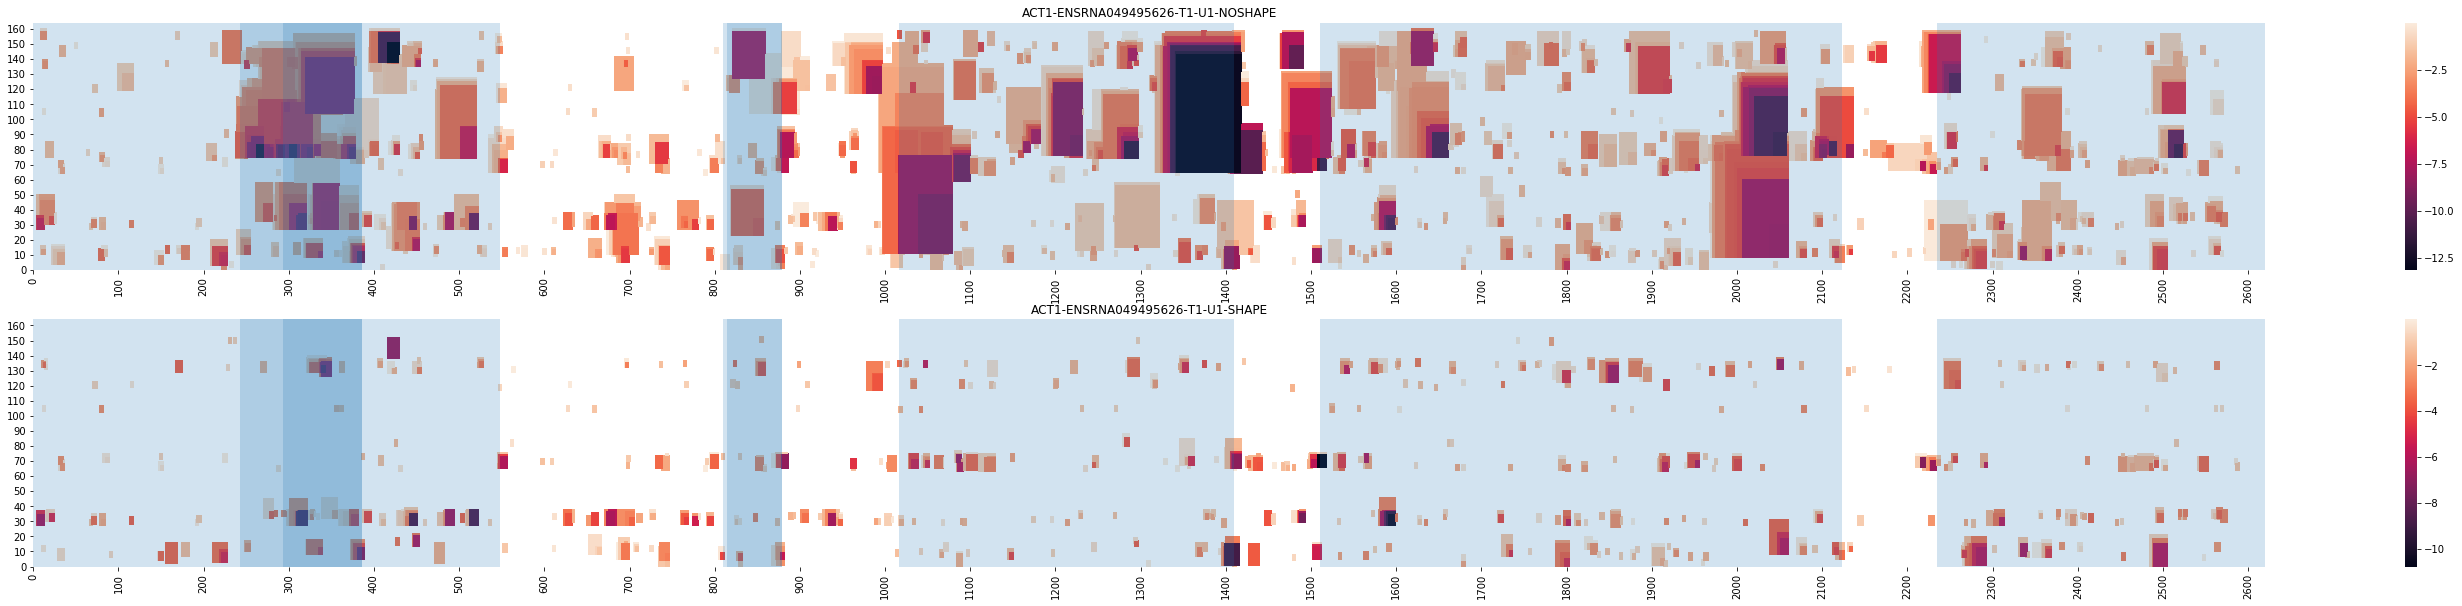

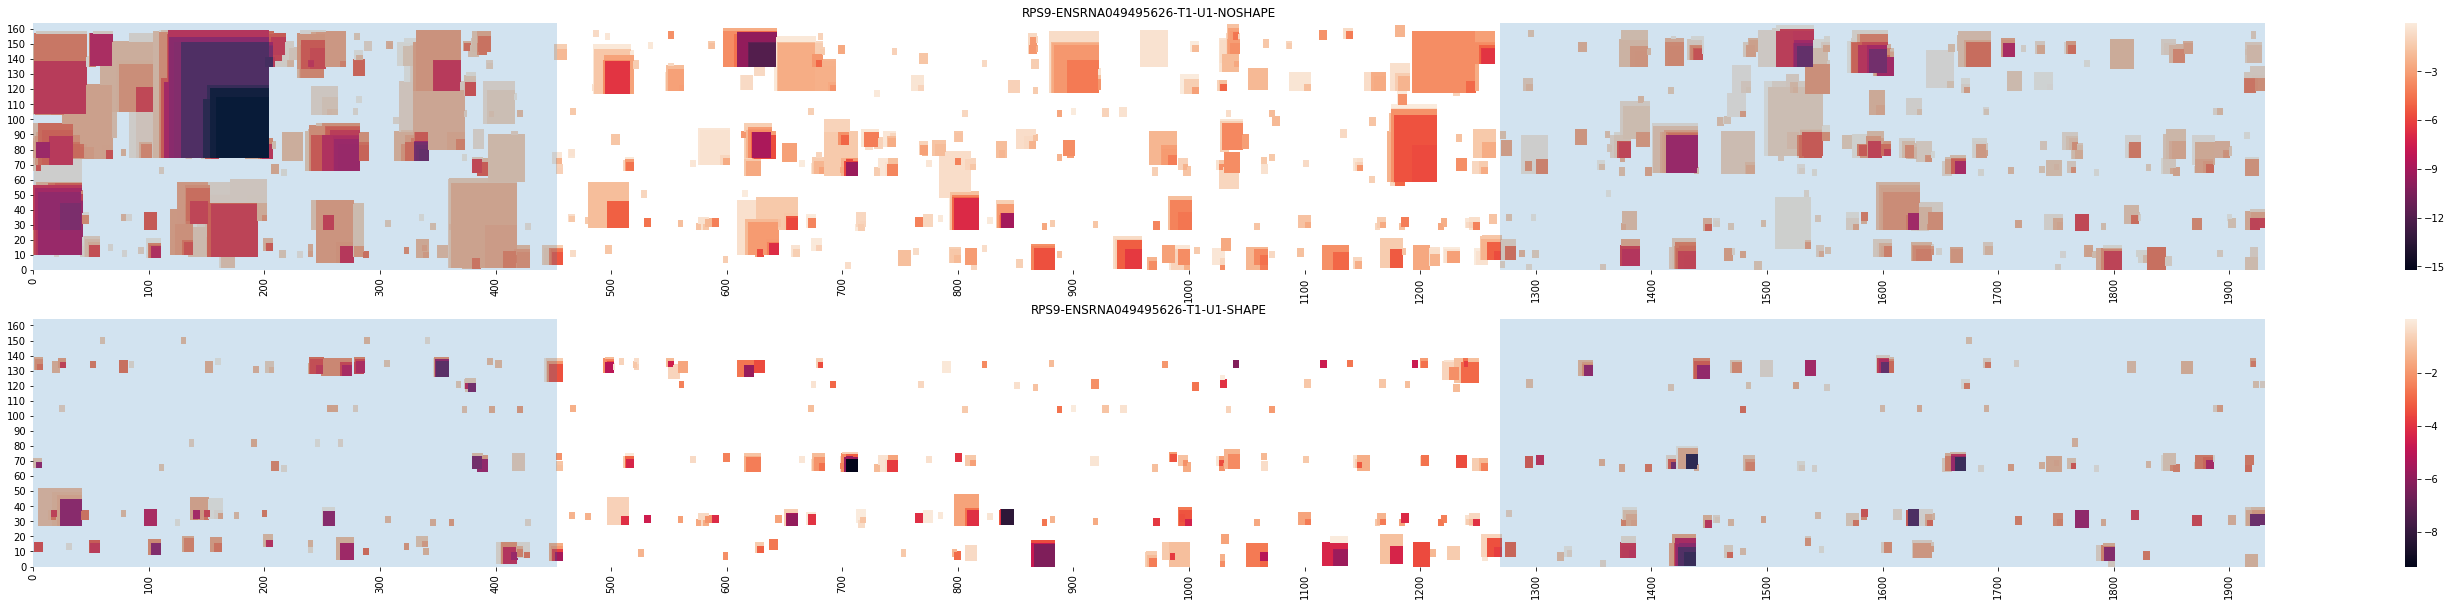

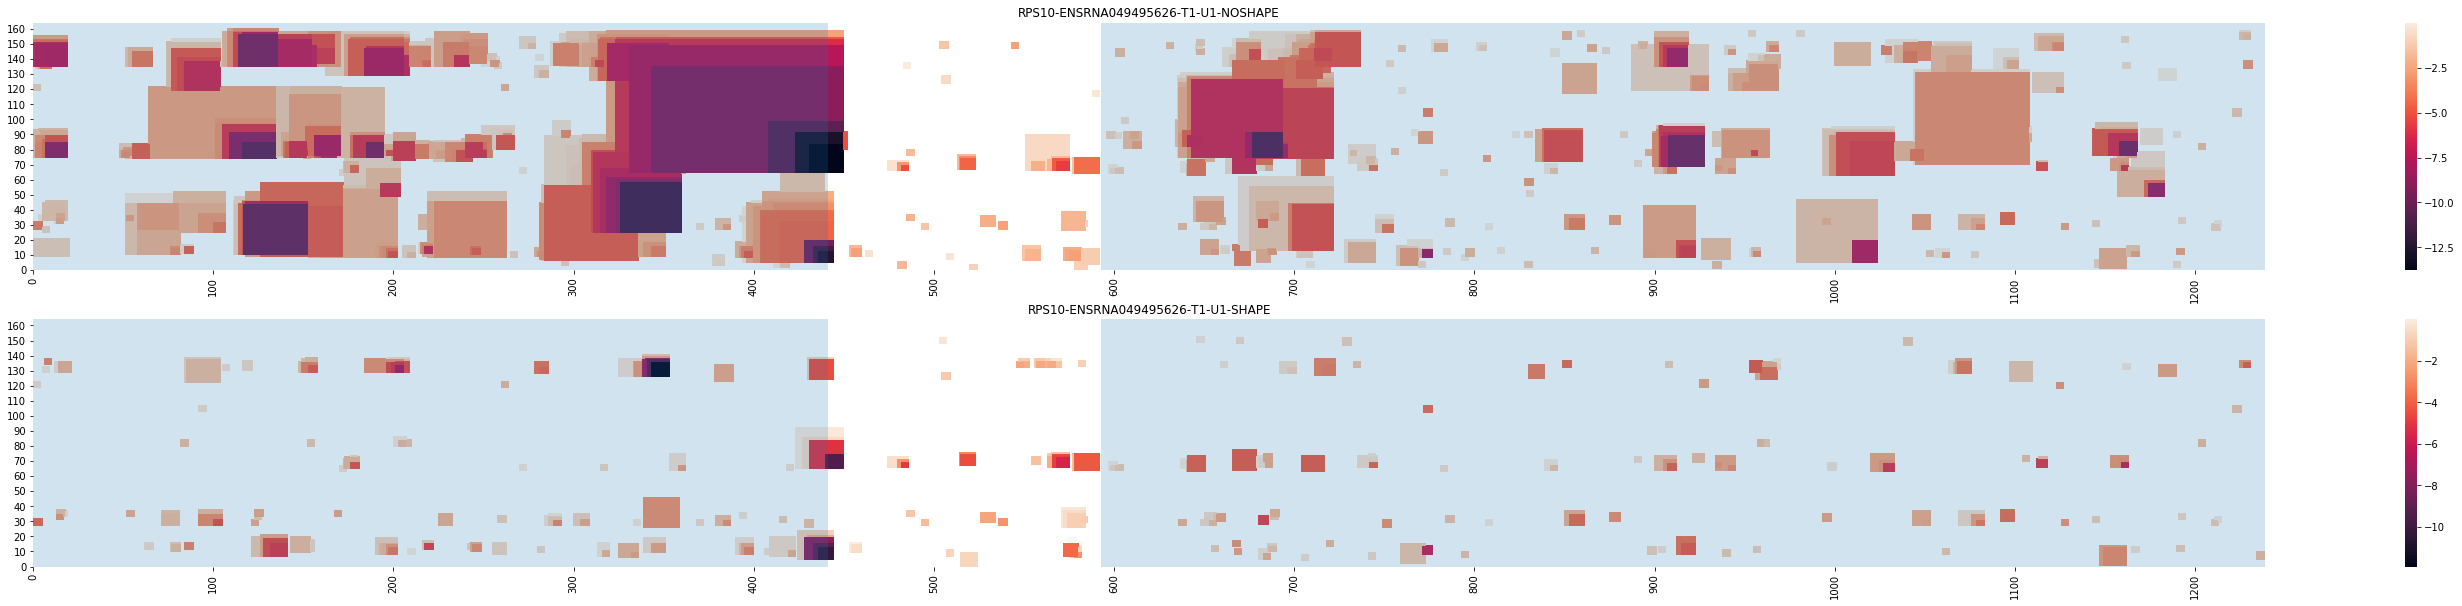

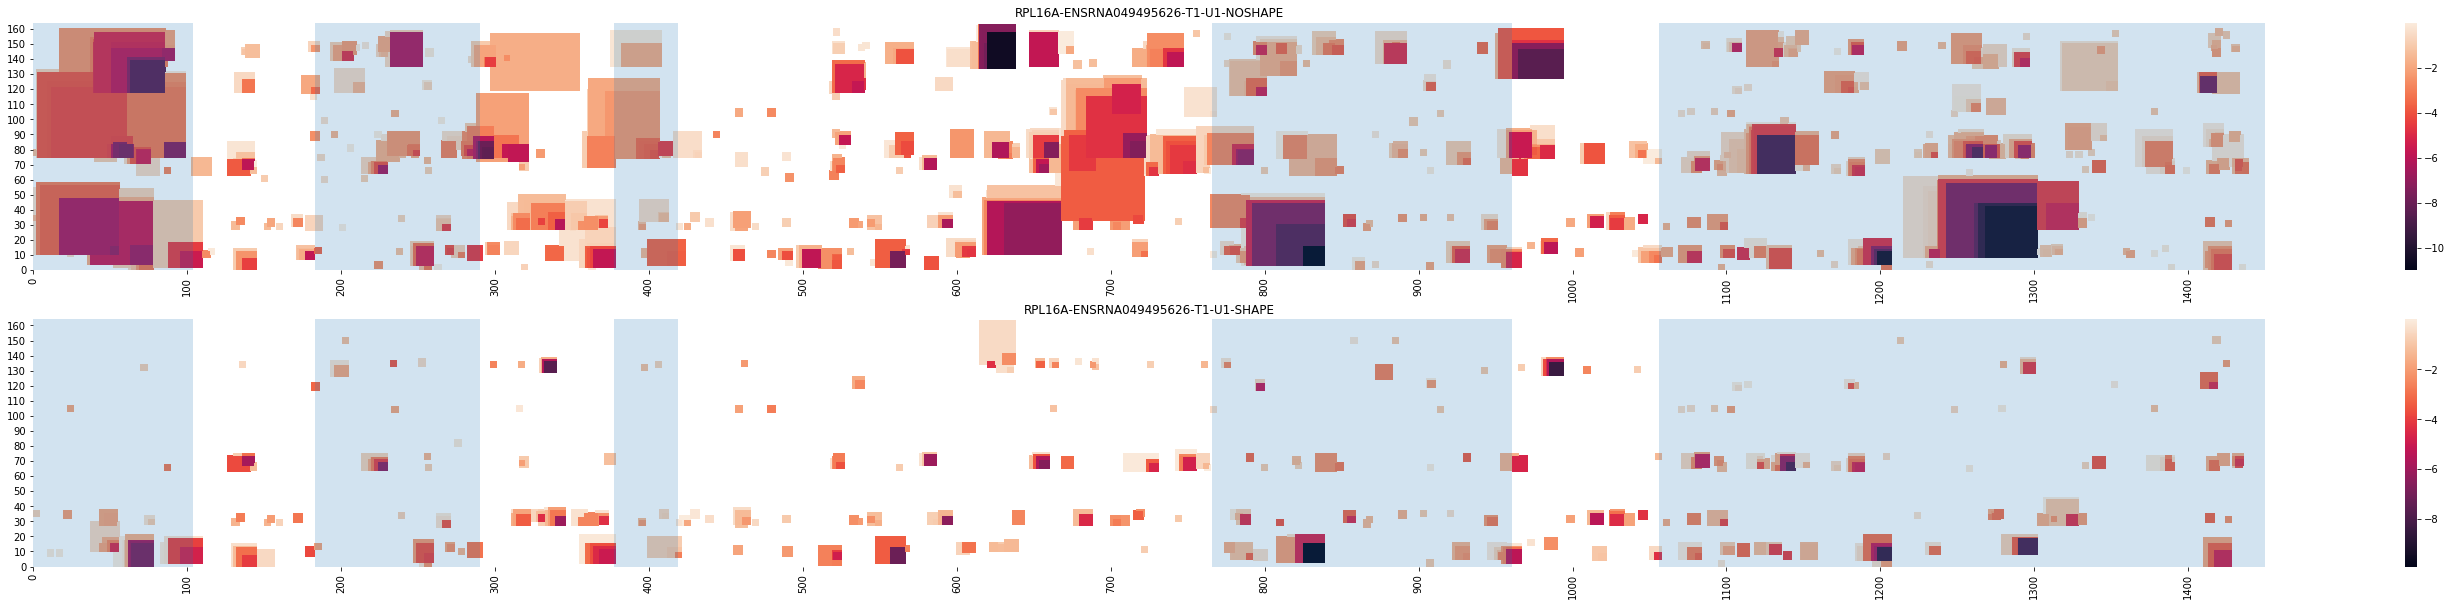

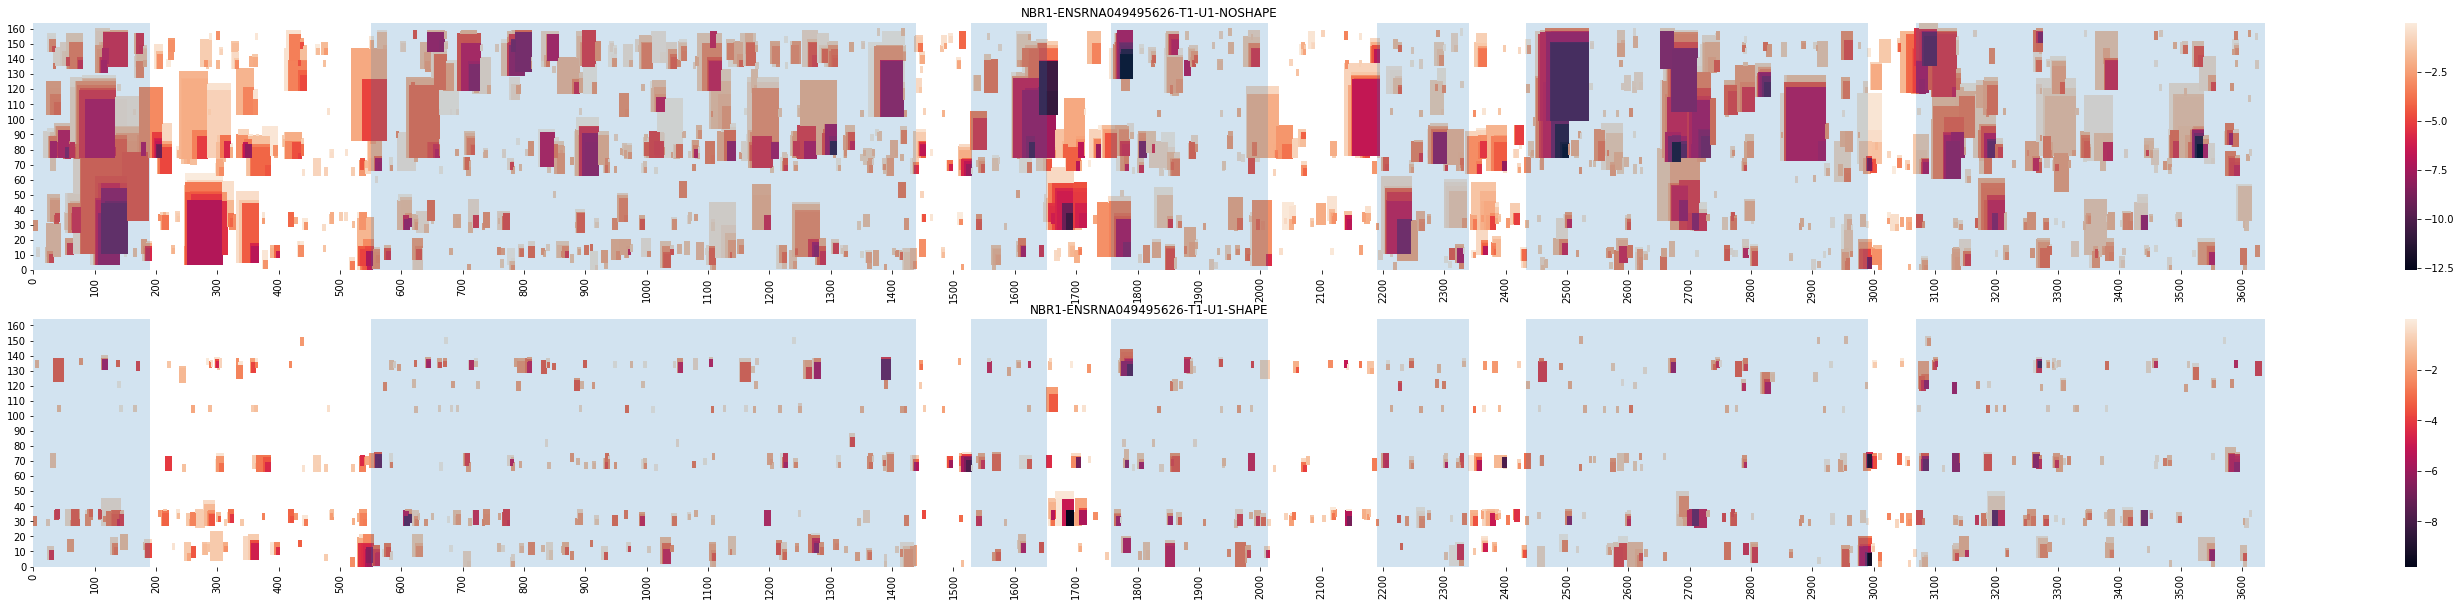

In [11]:
for gene in ['ACT1', 'RPS9', 'RPS10','RPL16A','NBR1',]:#'rps11','RPS11B',:
    run_all_for_a_gene(gene)
    

gunzip -c /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;' > ACT1.gff
       seqname  source feature     start       end score strand
0  NC_003071.7  RefSeq    gene  15778941  15781561     .      +
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
b''
bedtools getfasta on  ACT1-genomic.fa
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv  -n 20 --outOverlap=B --outMode=C --seedBP=4 --temperature 22  
b''
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --qAccFile=ENSRNA049495626-T1-U1_0001_

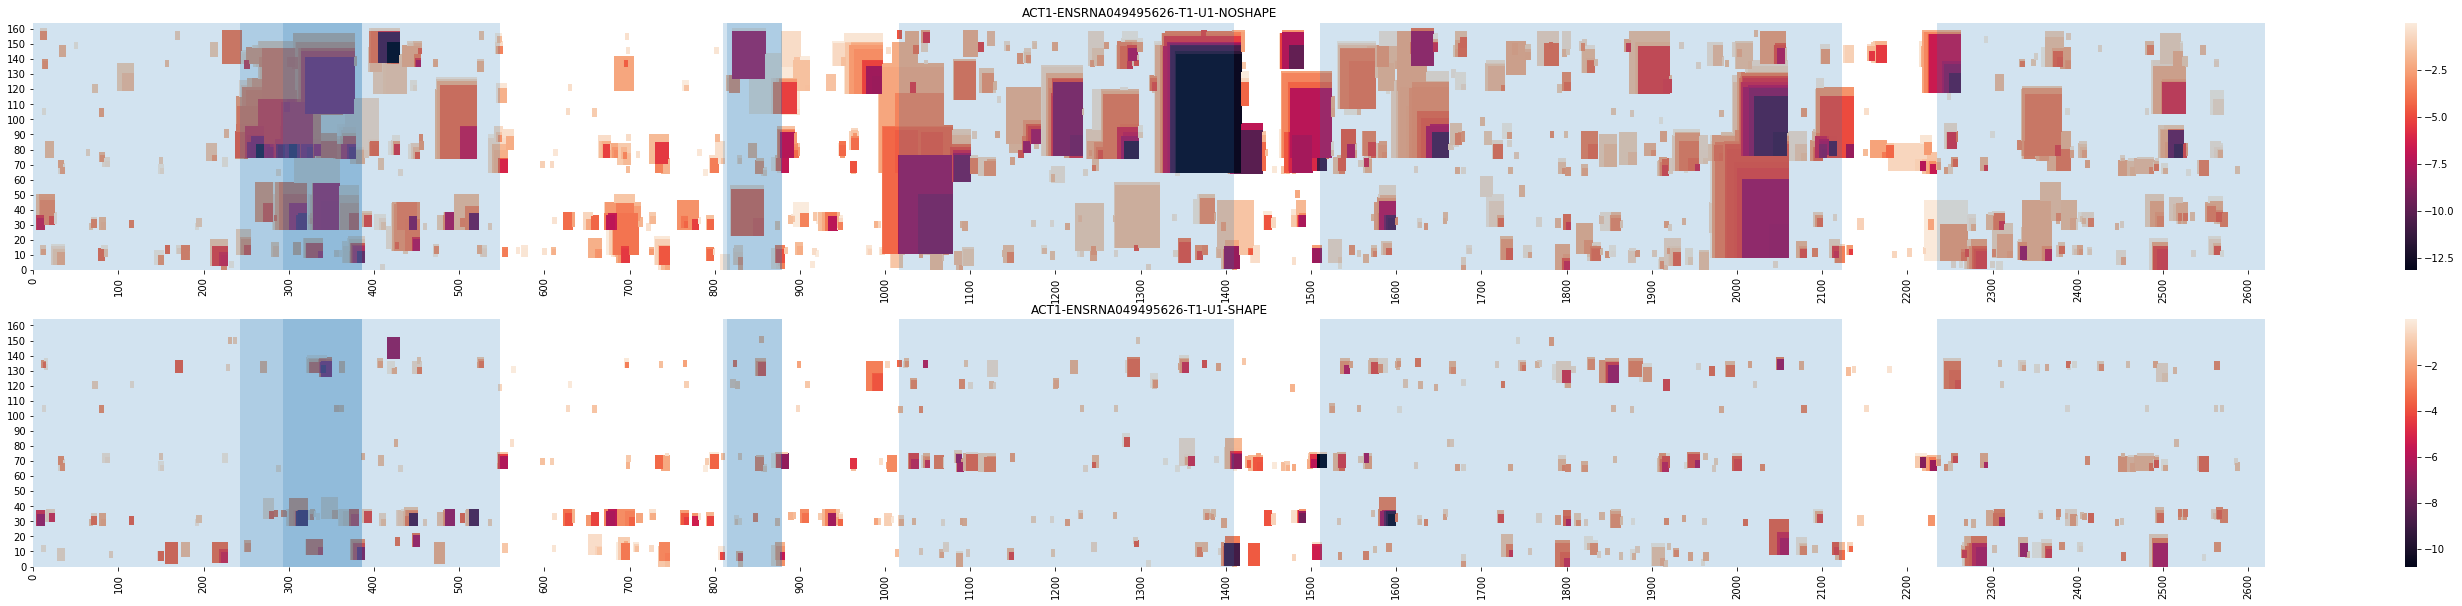

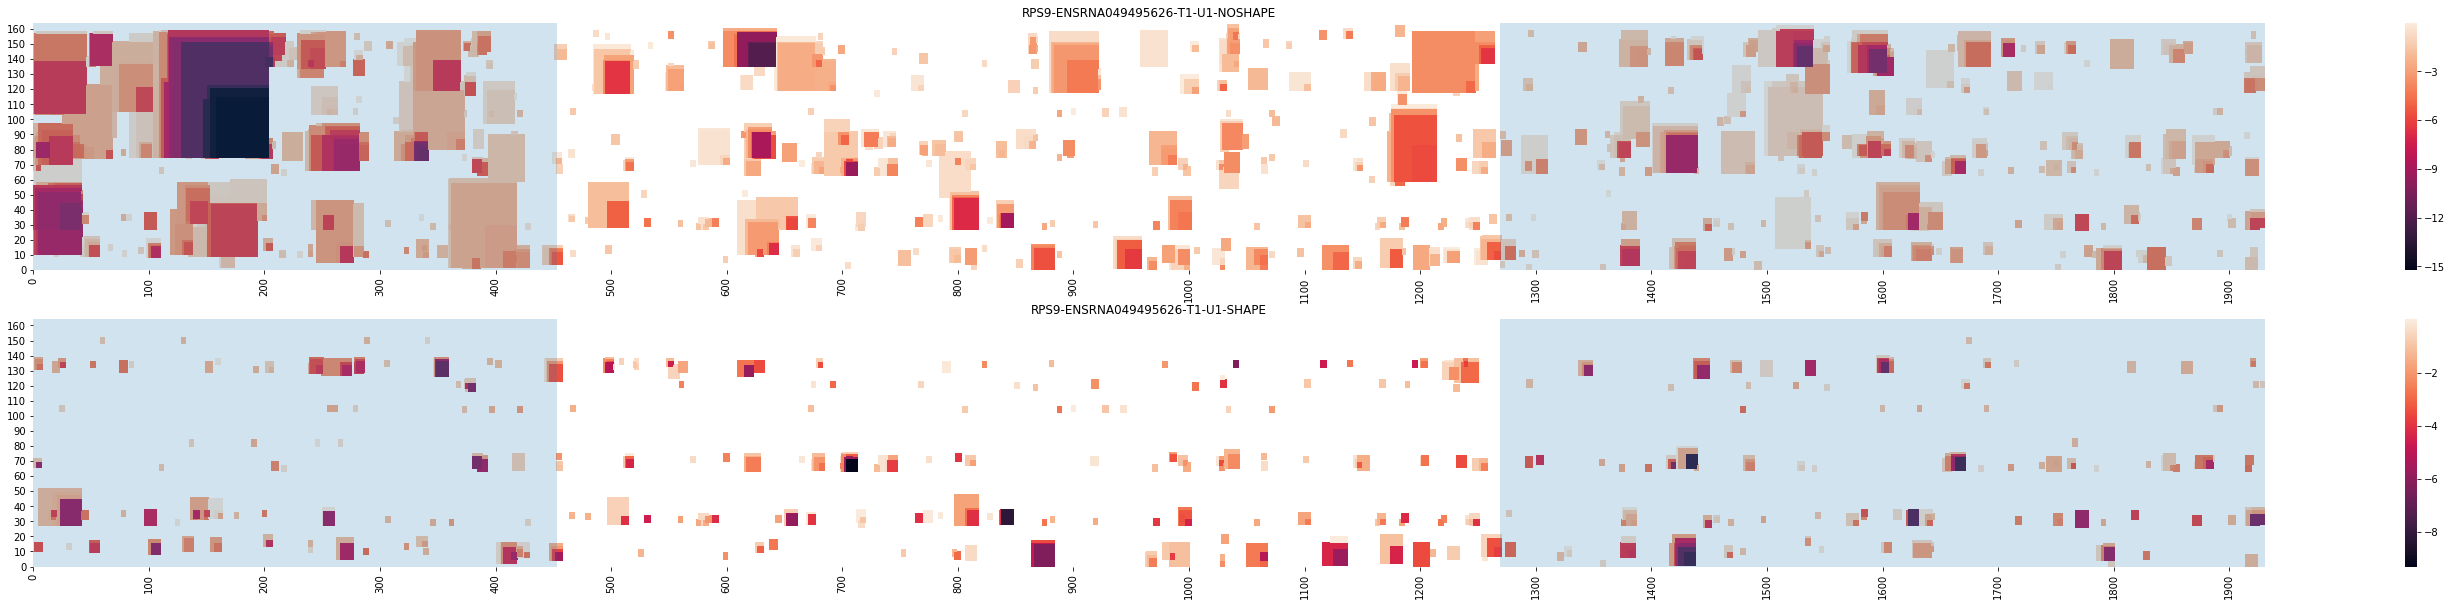

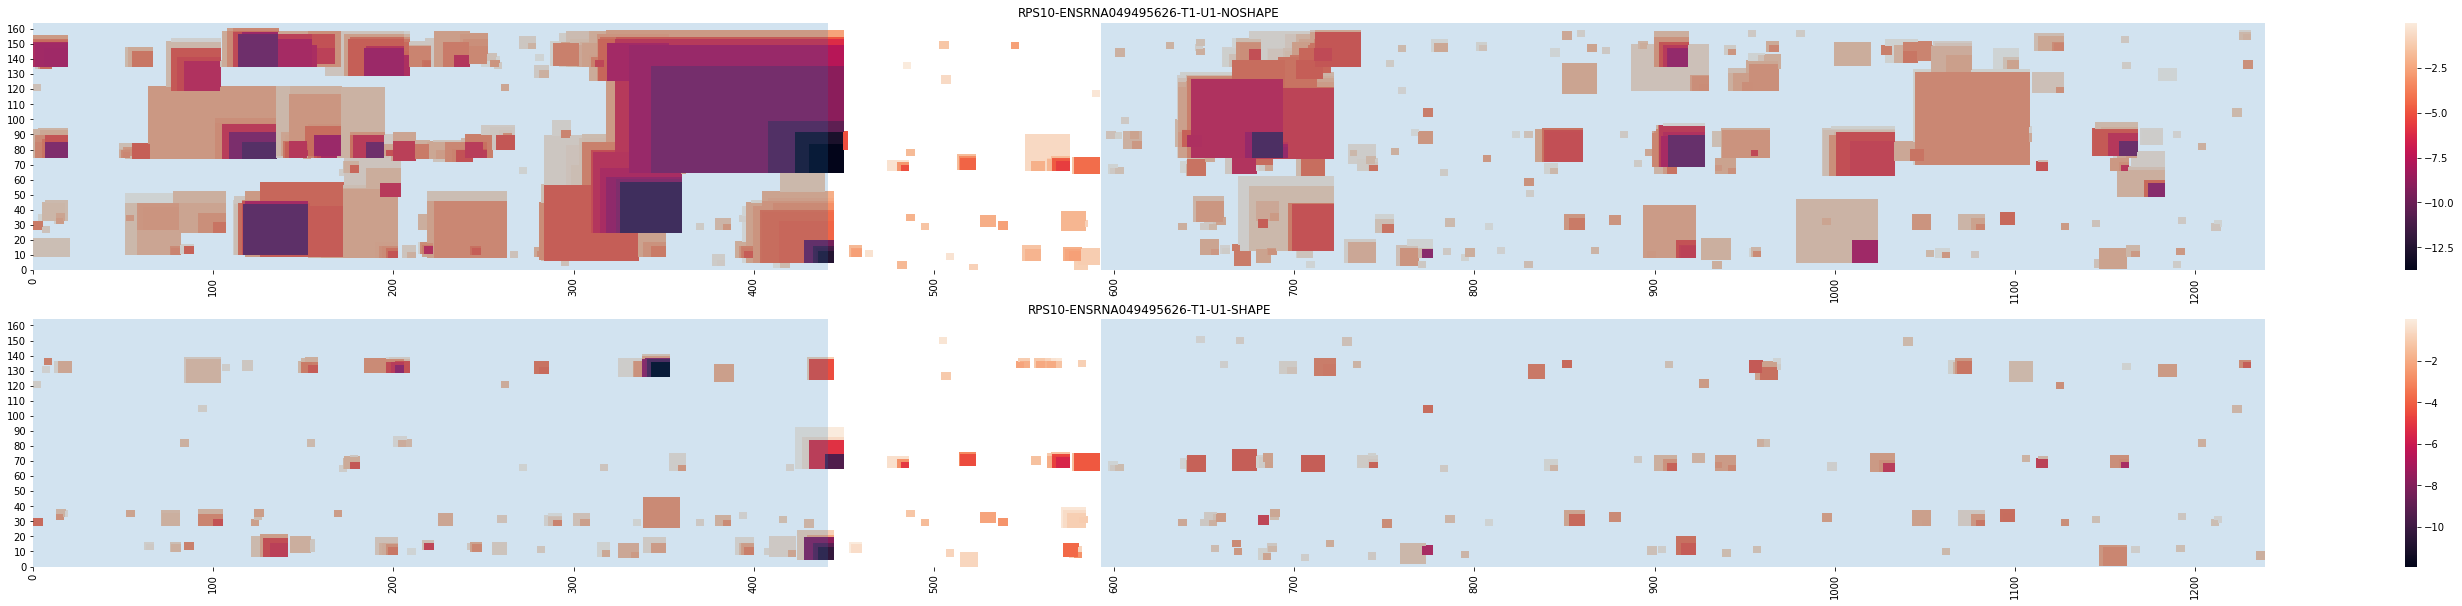

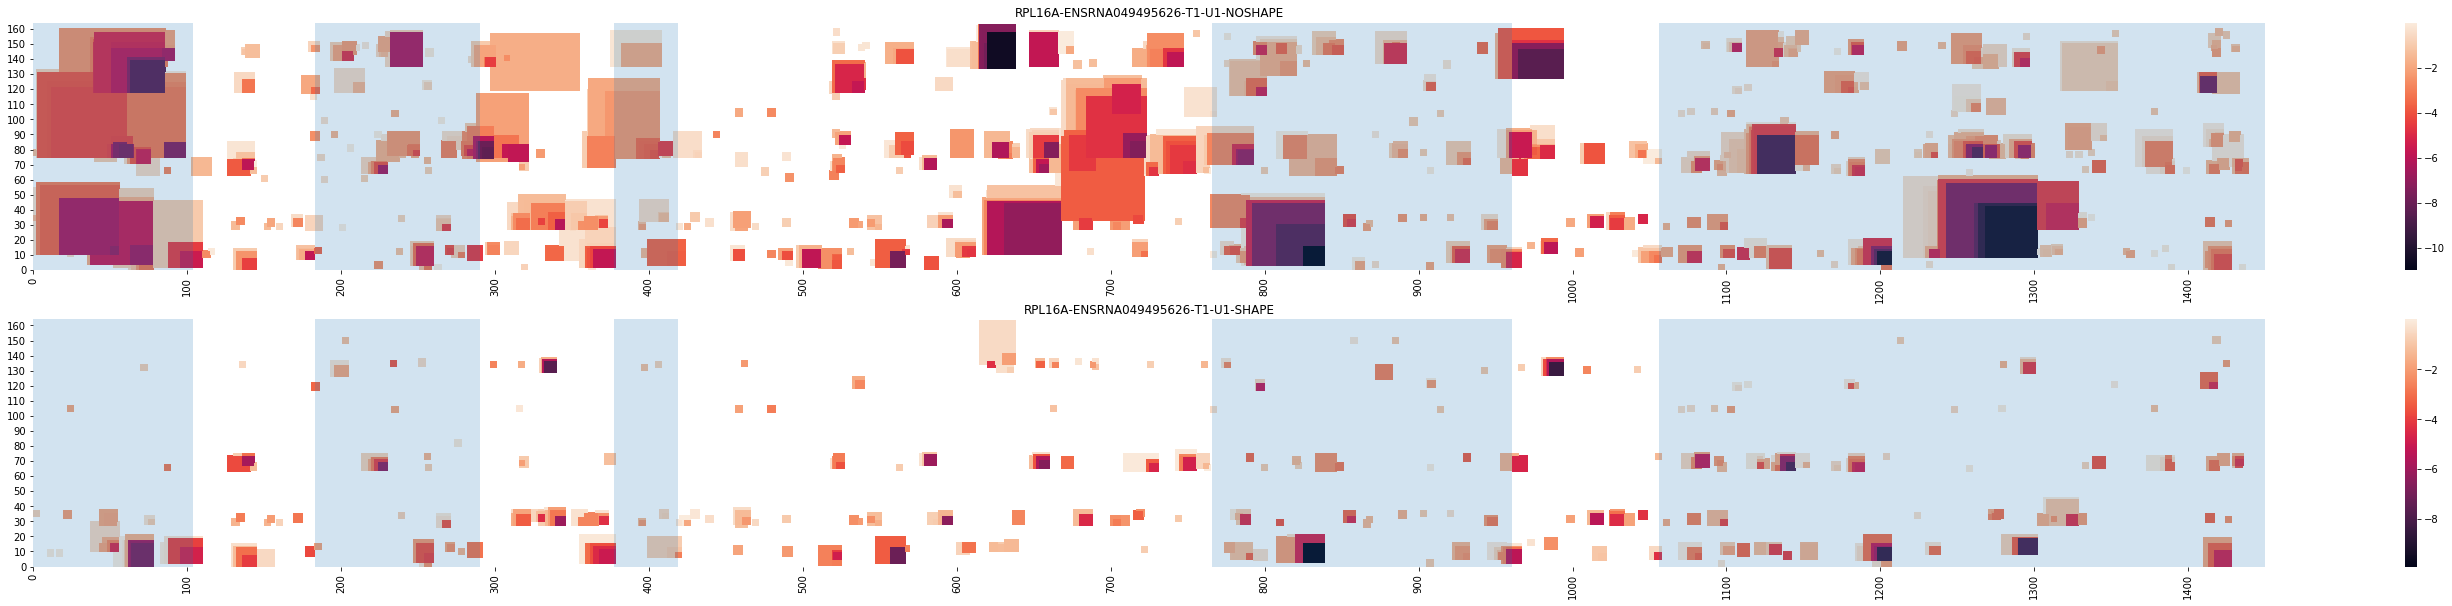

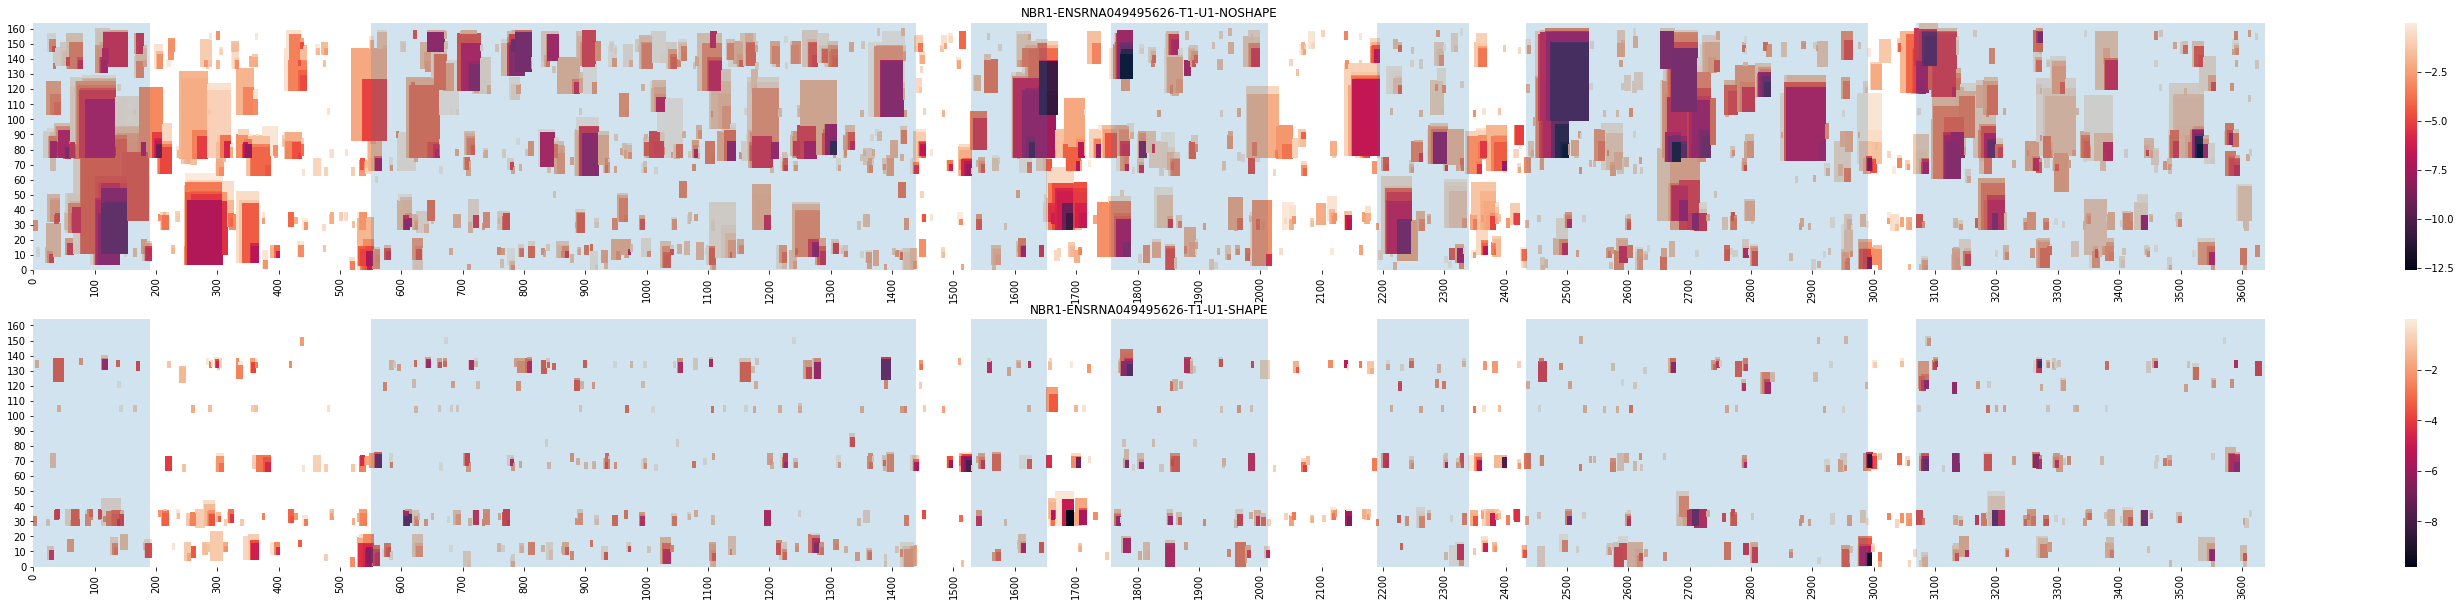

gunzip -c /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;' > ACT1.gff
       seqname  source feature     start       end score strand
0  NC_003071.7  RefSeq    gene  15778941  15781561     .      +
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
b''
bedtools getfasta on  ACT1-genomic.fa
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv  -n 20 --outOverlap=B --outMode=C --seedBP=4 
b''
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --qAccFile=ENSRNA049495626-T1-U1_0001_lunp  -n 20 --outO

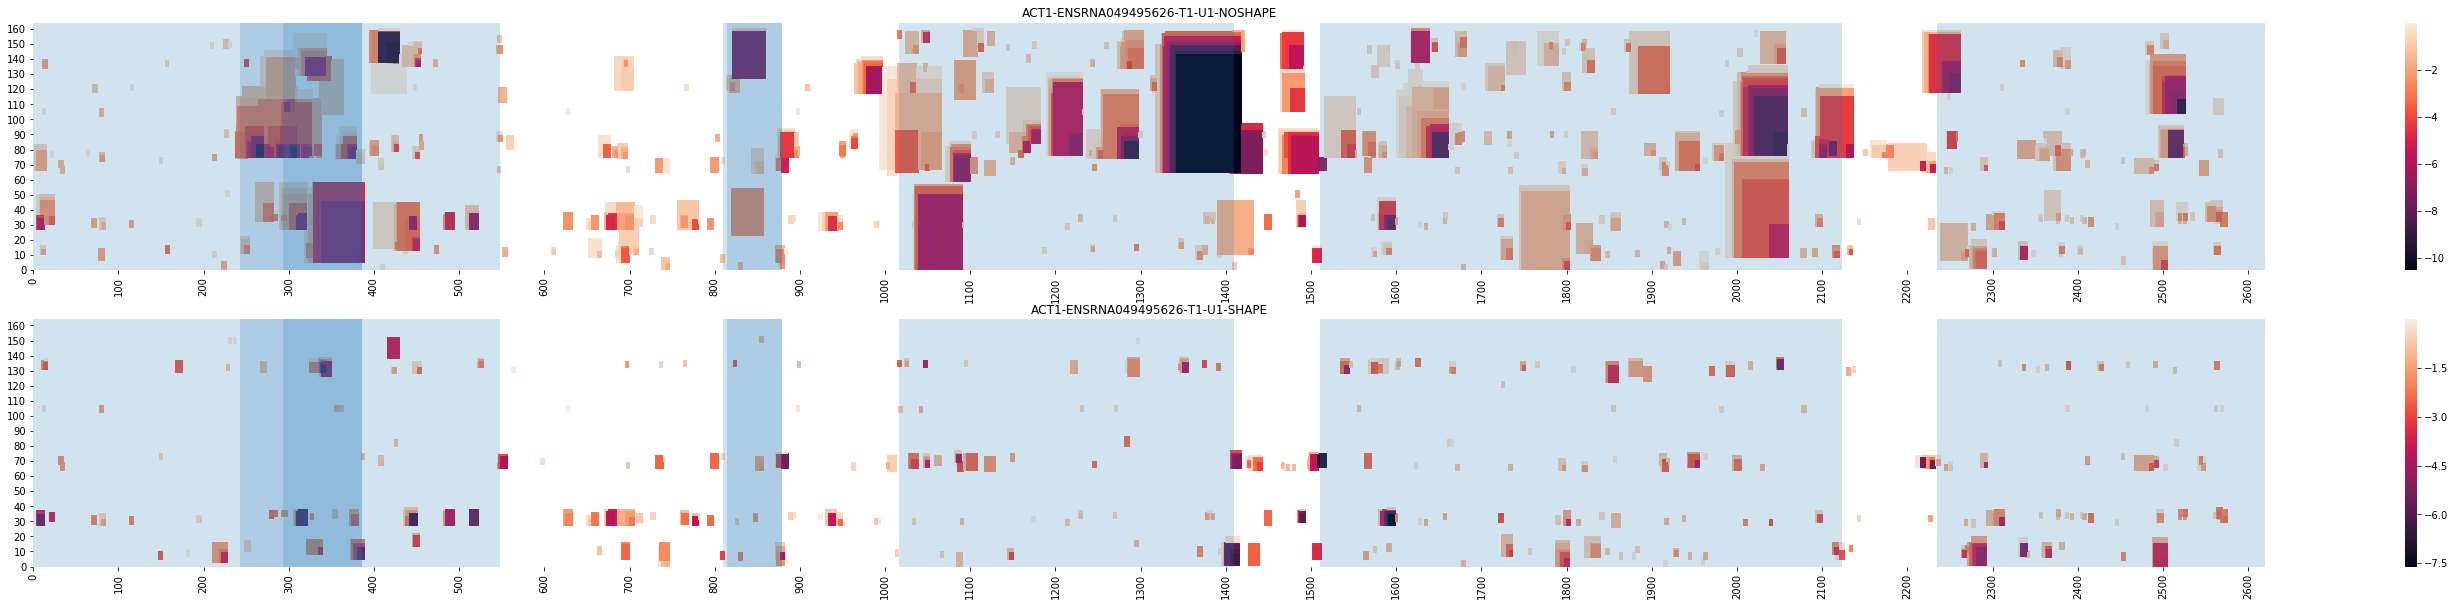

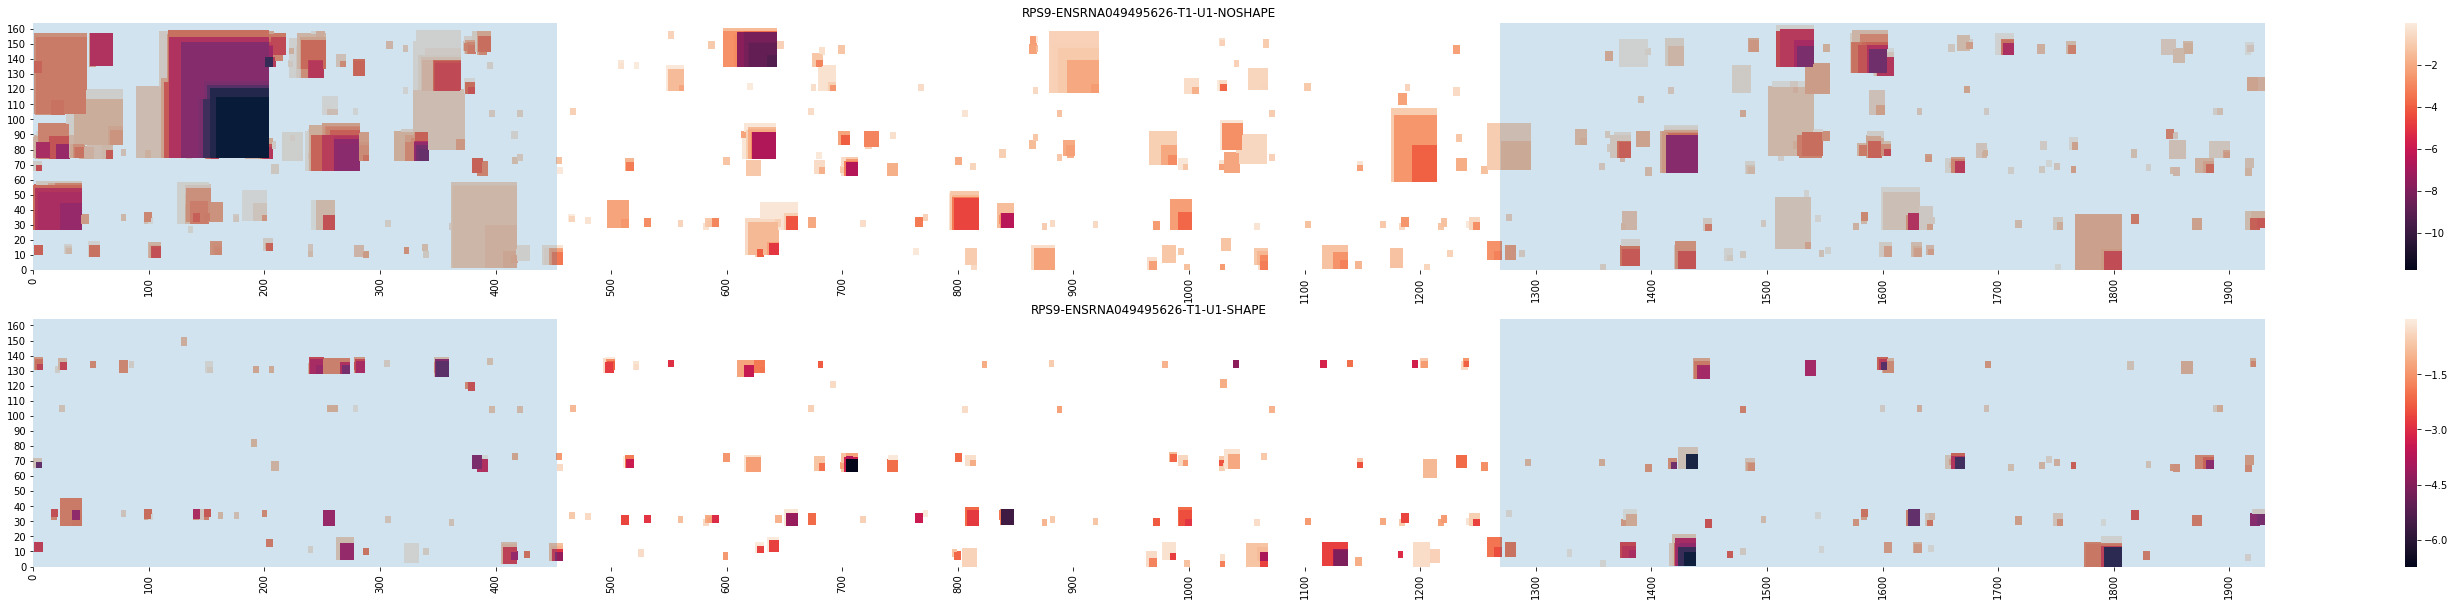

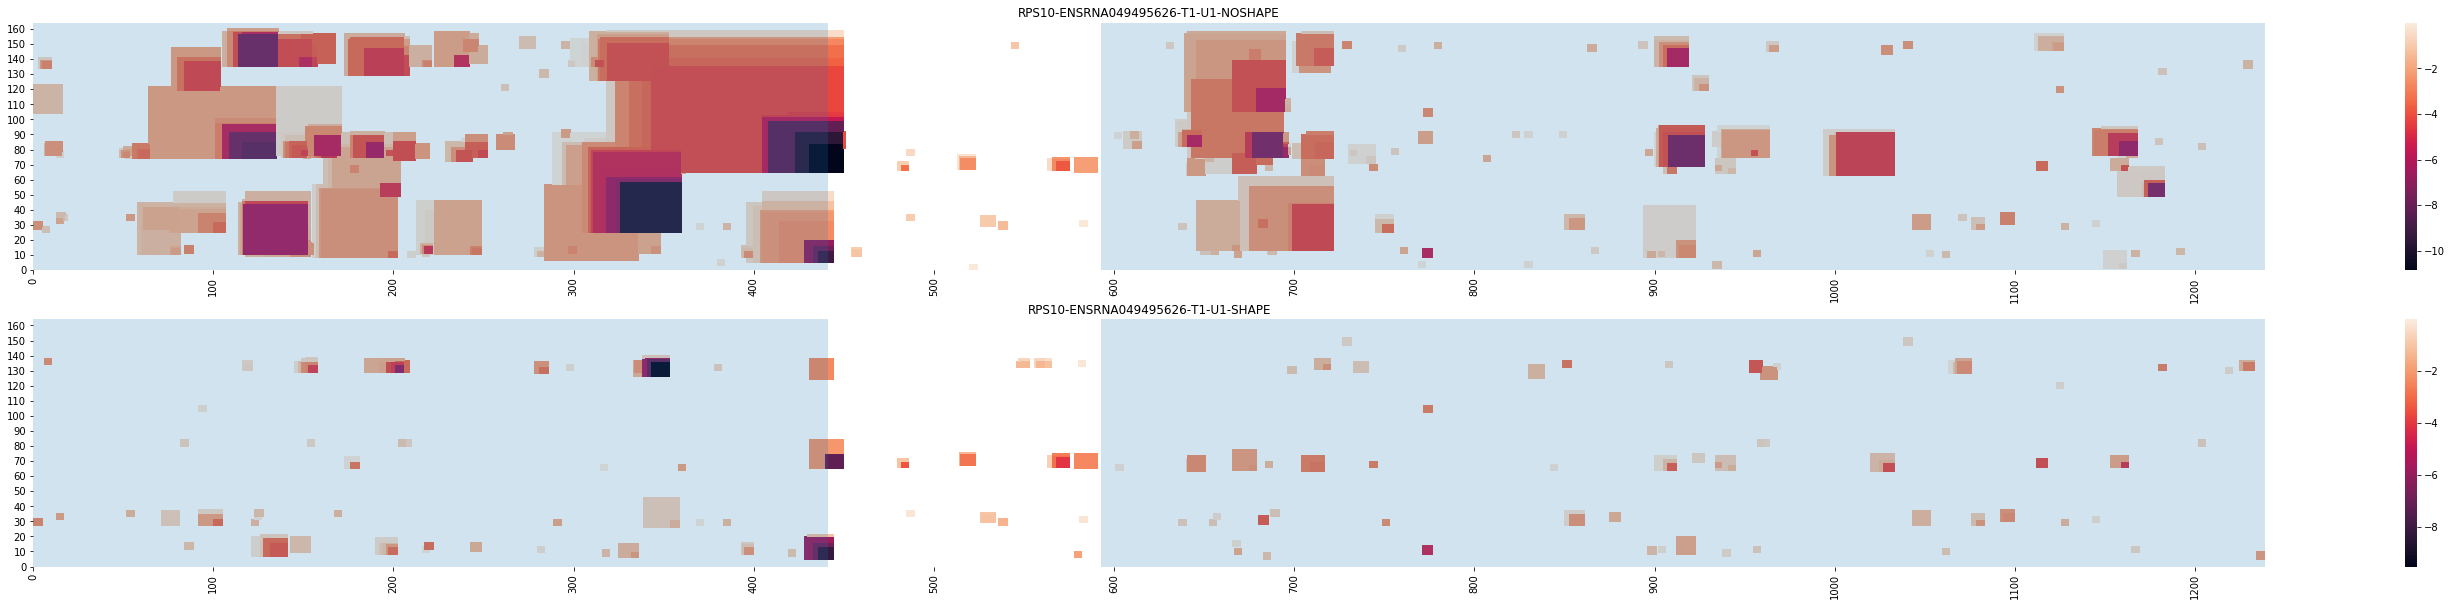

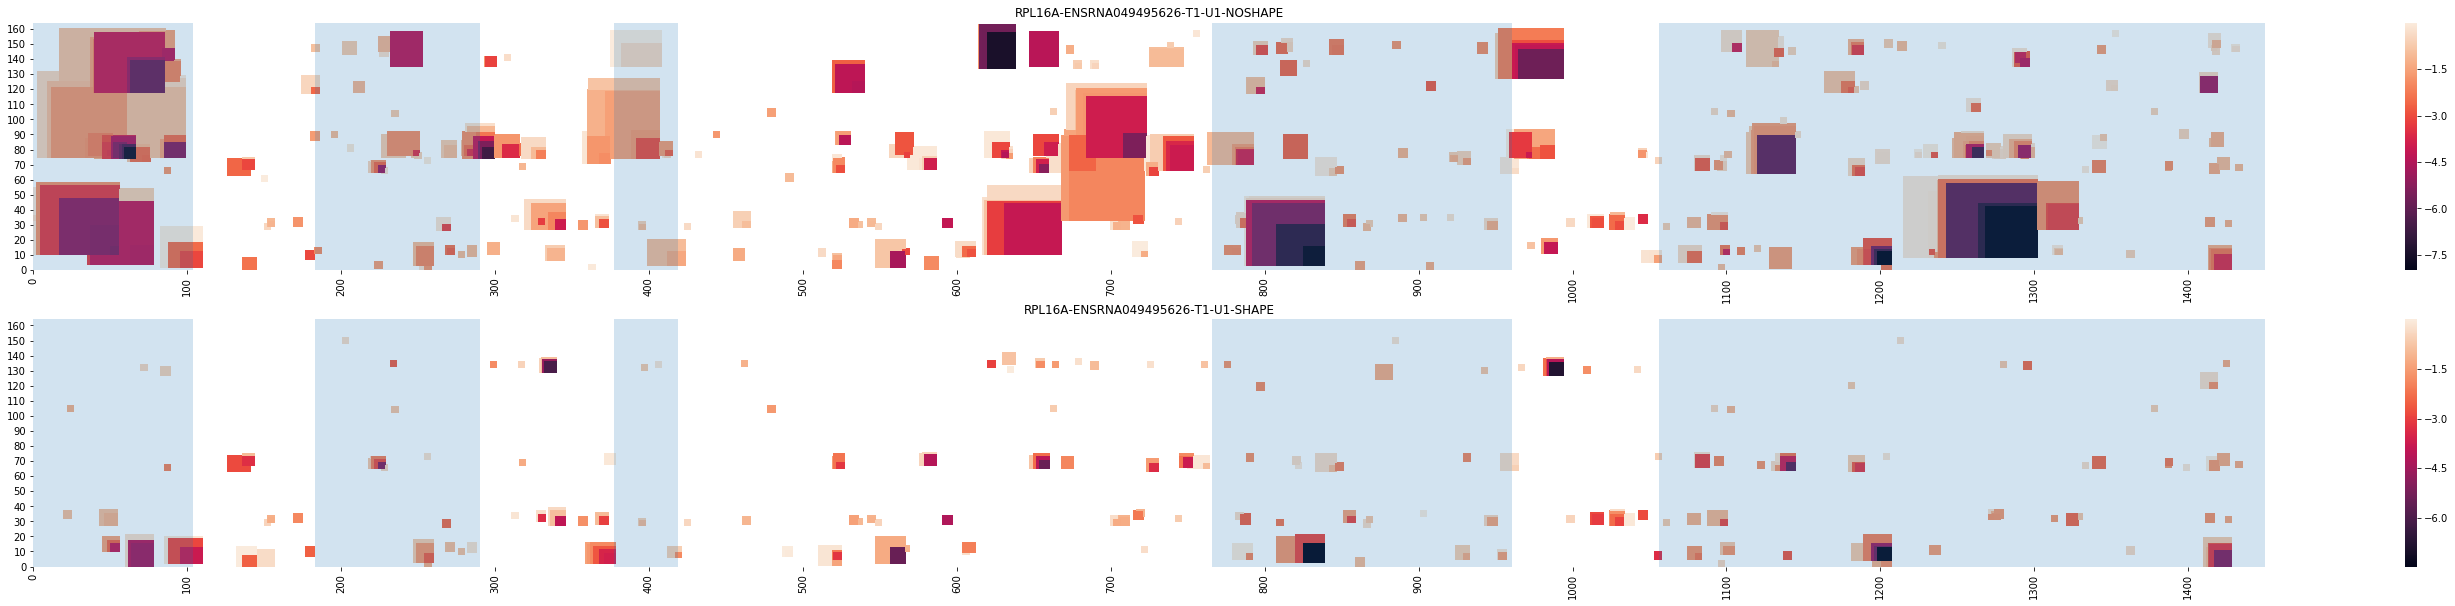

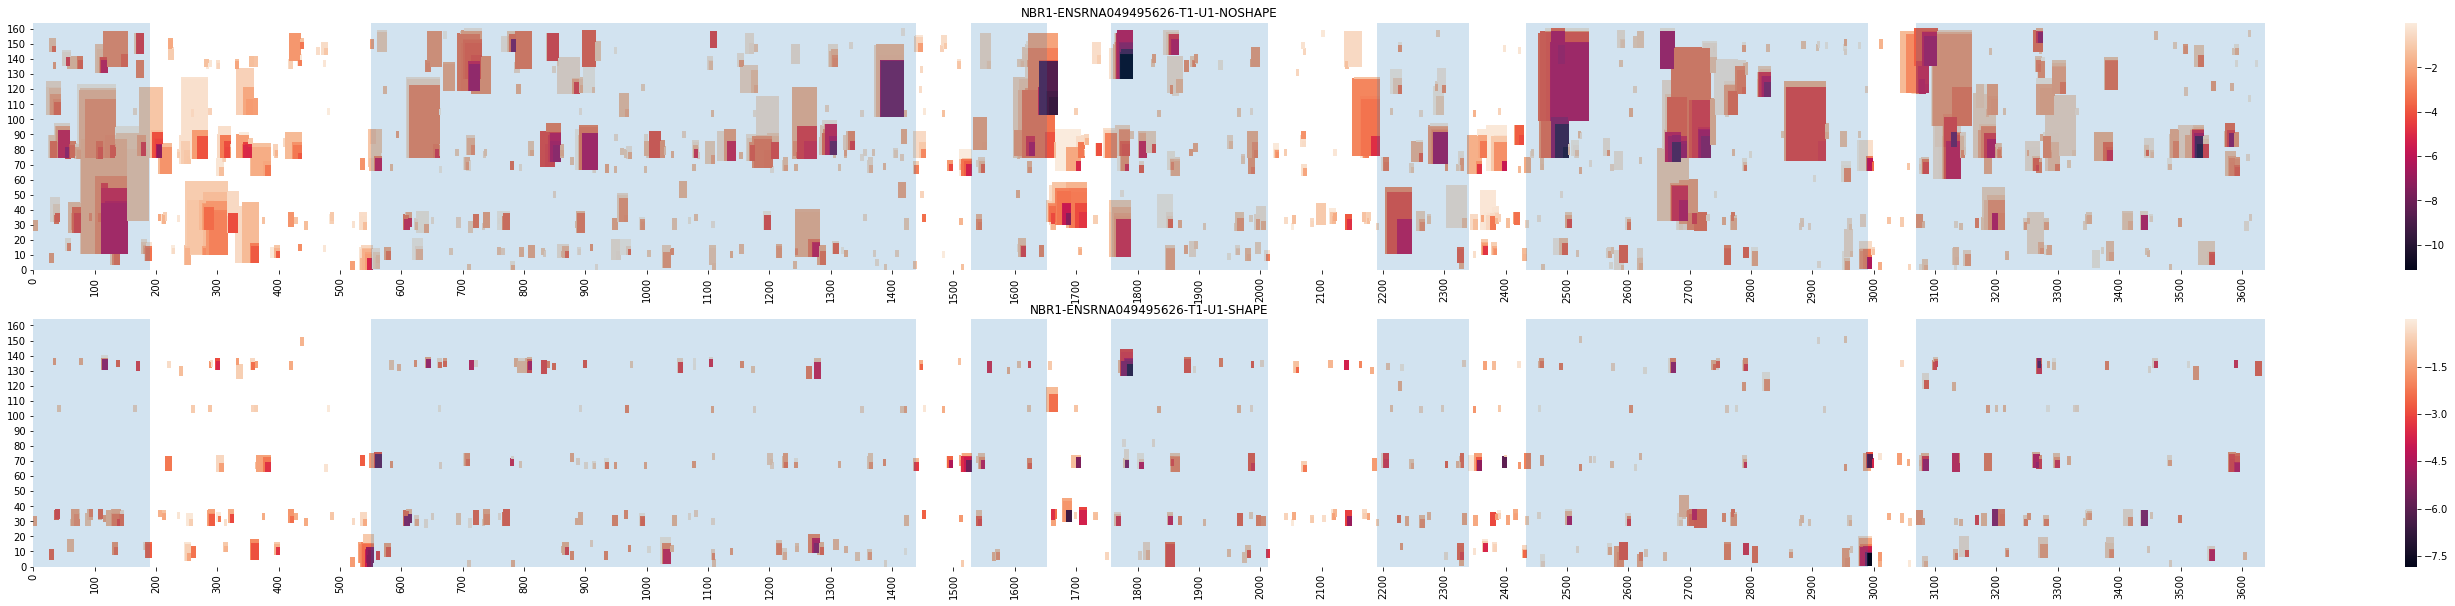

gunzip -c /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;' > ACT1.gff
       seqname  source feature     start       end score strand
0  NC_003071.7  RefSeq    gene  15778941  15781561     .      +
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
b''
bedtools getfasta on  ACT1-genomic.fa
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv  -n 20 --outOverlap=Q --outMode=C --seedBP=5 
b''
IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1_SHAPE.csv --qAccFile=ENSRNA049495626-T1-U1_0001_lunp  -n 20 --outO

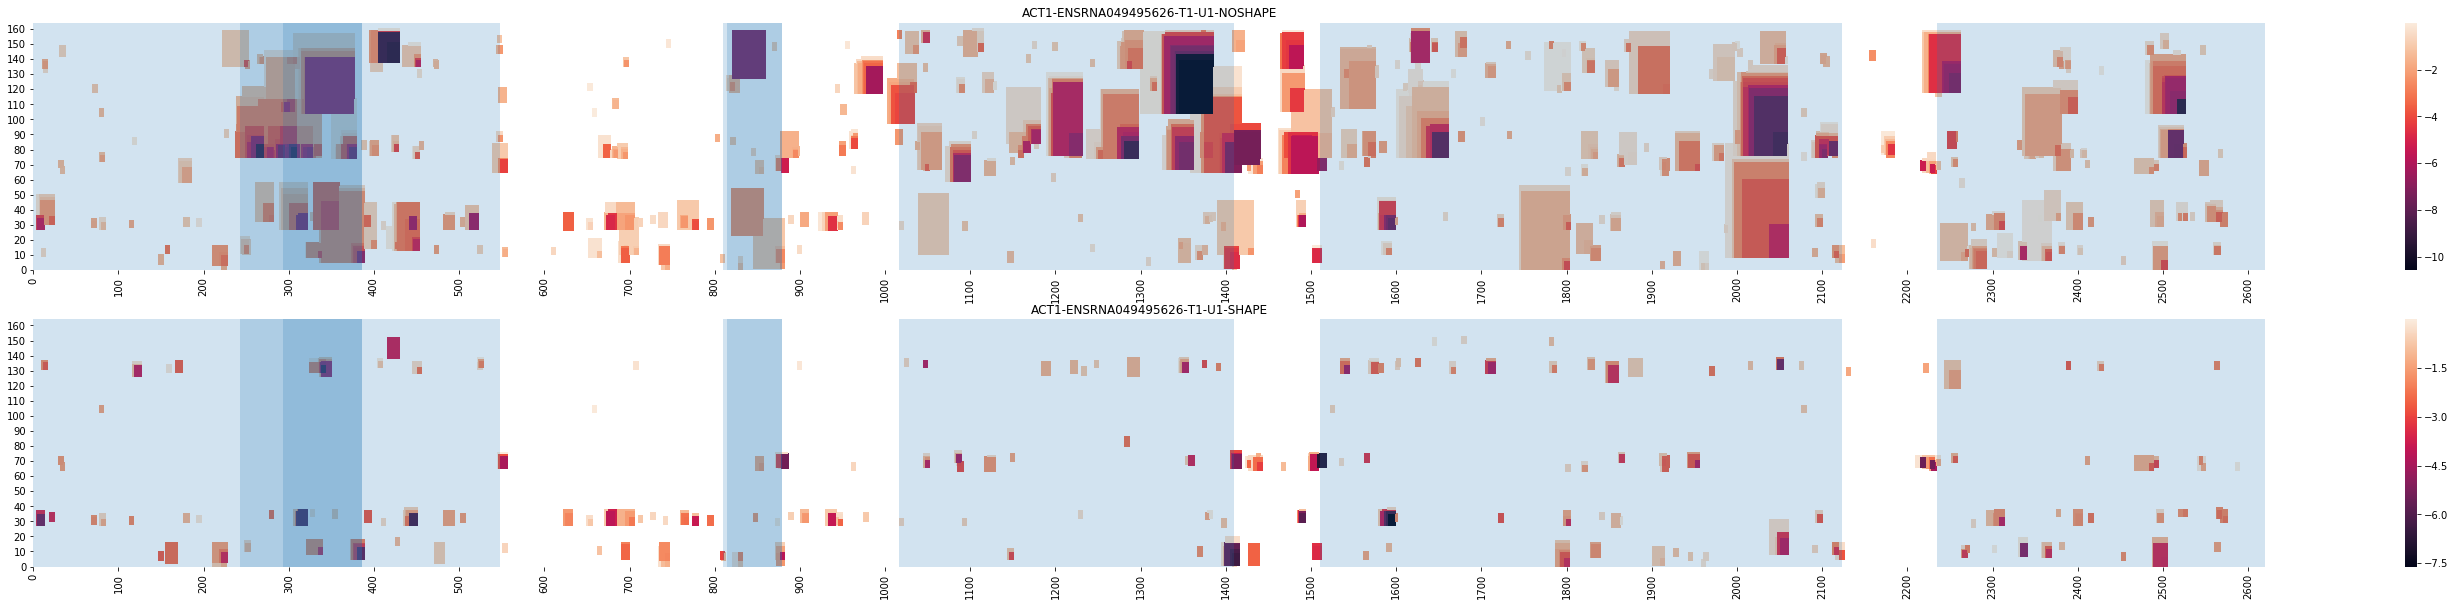

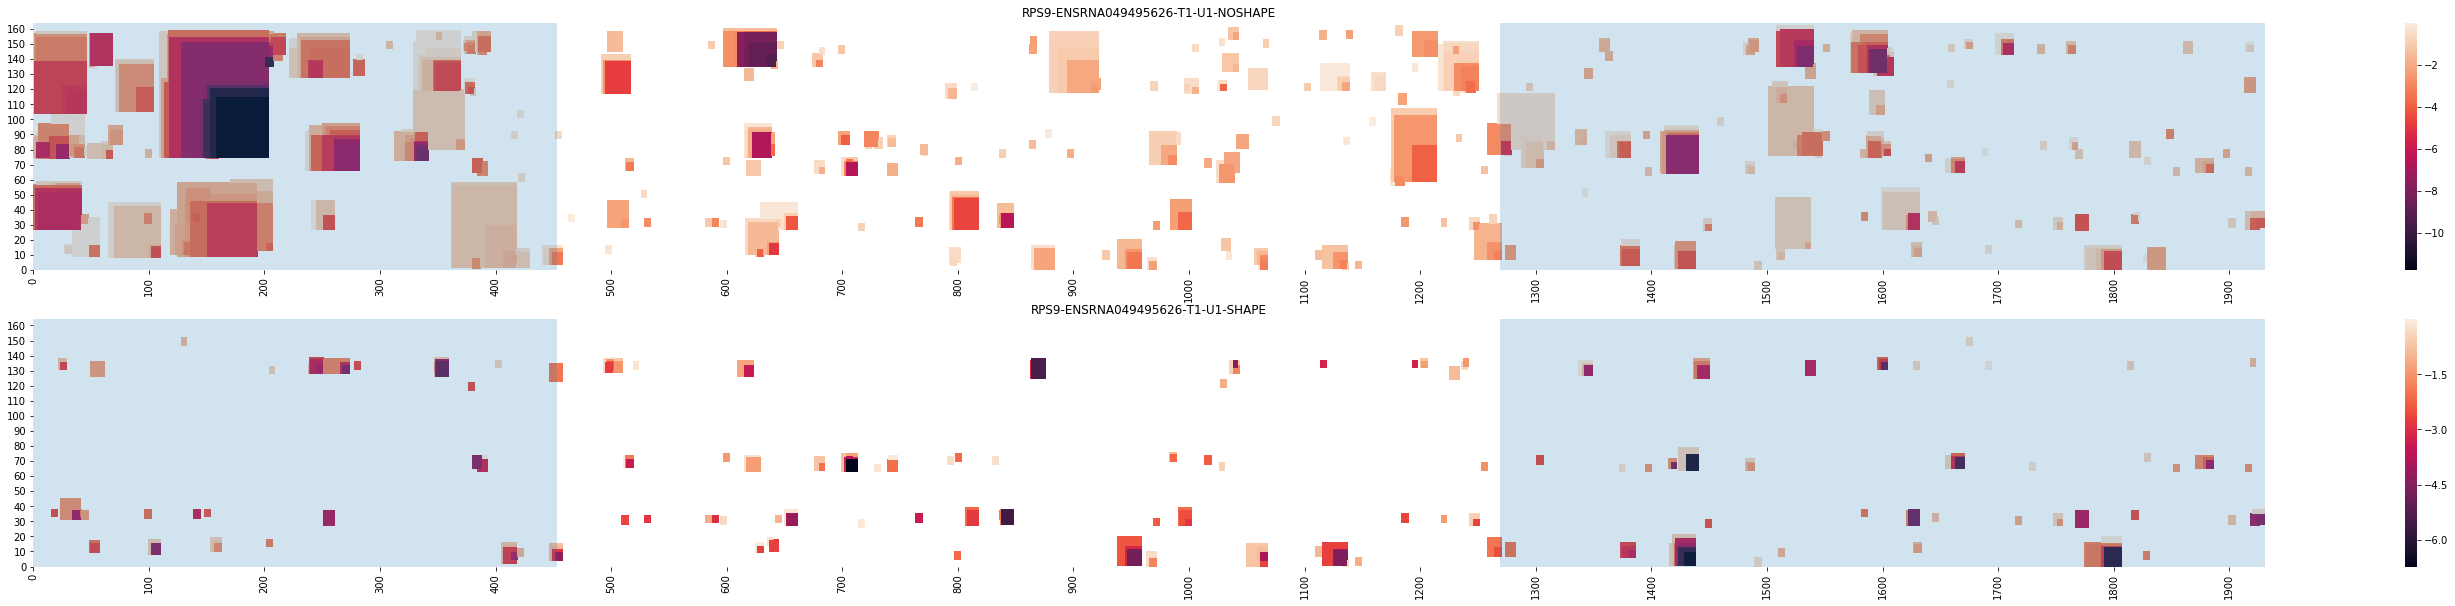

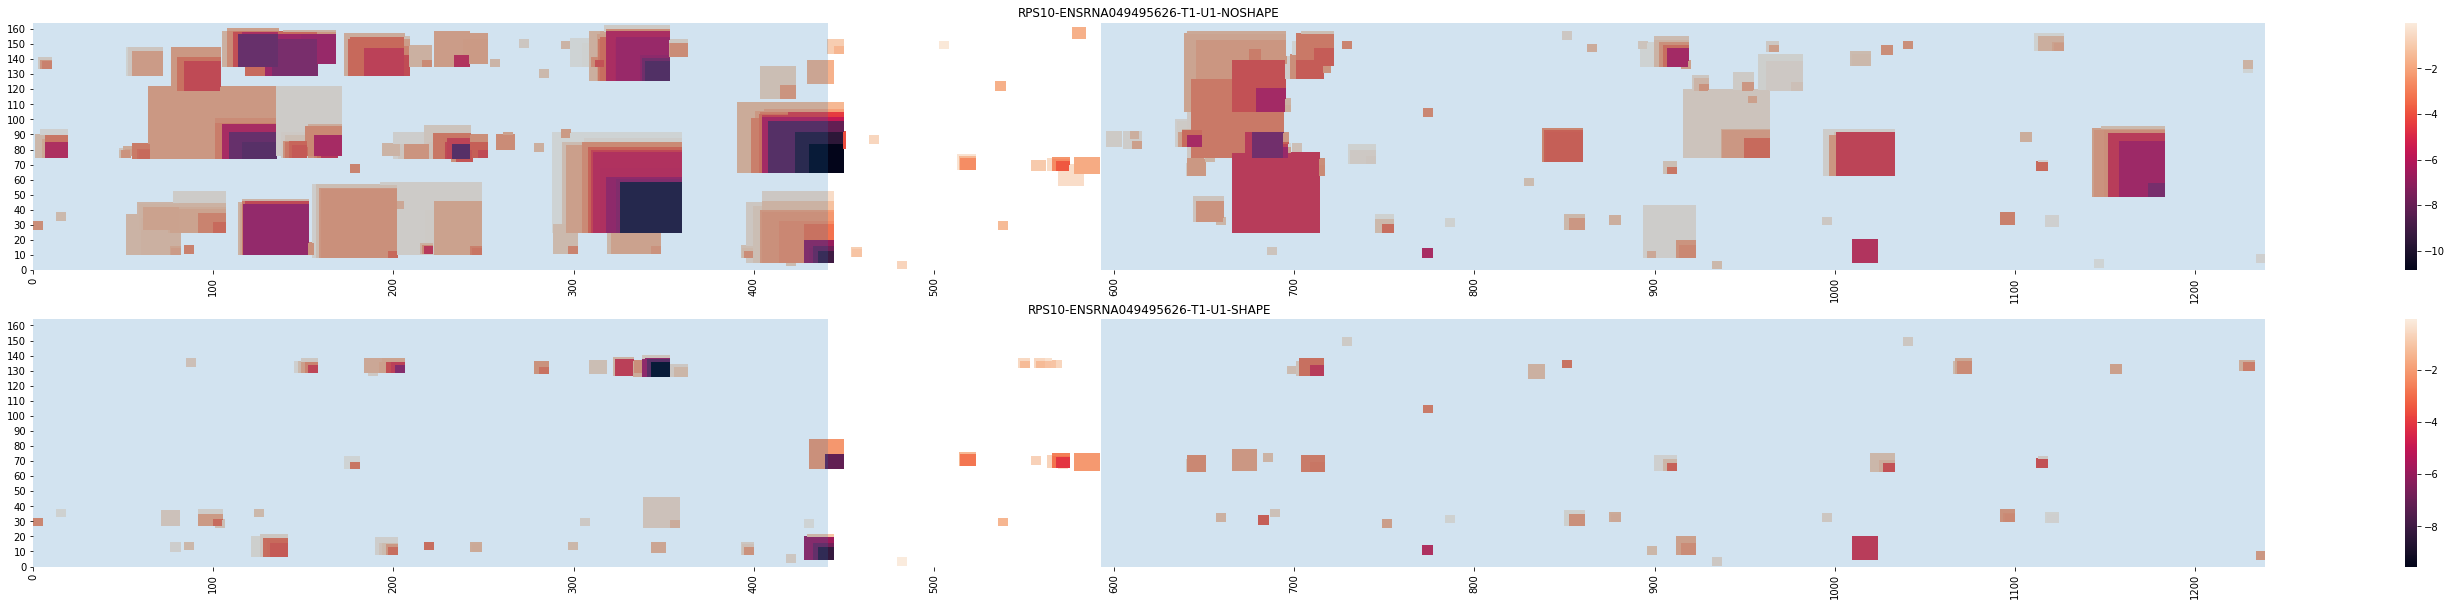

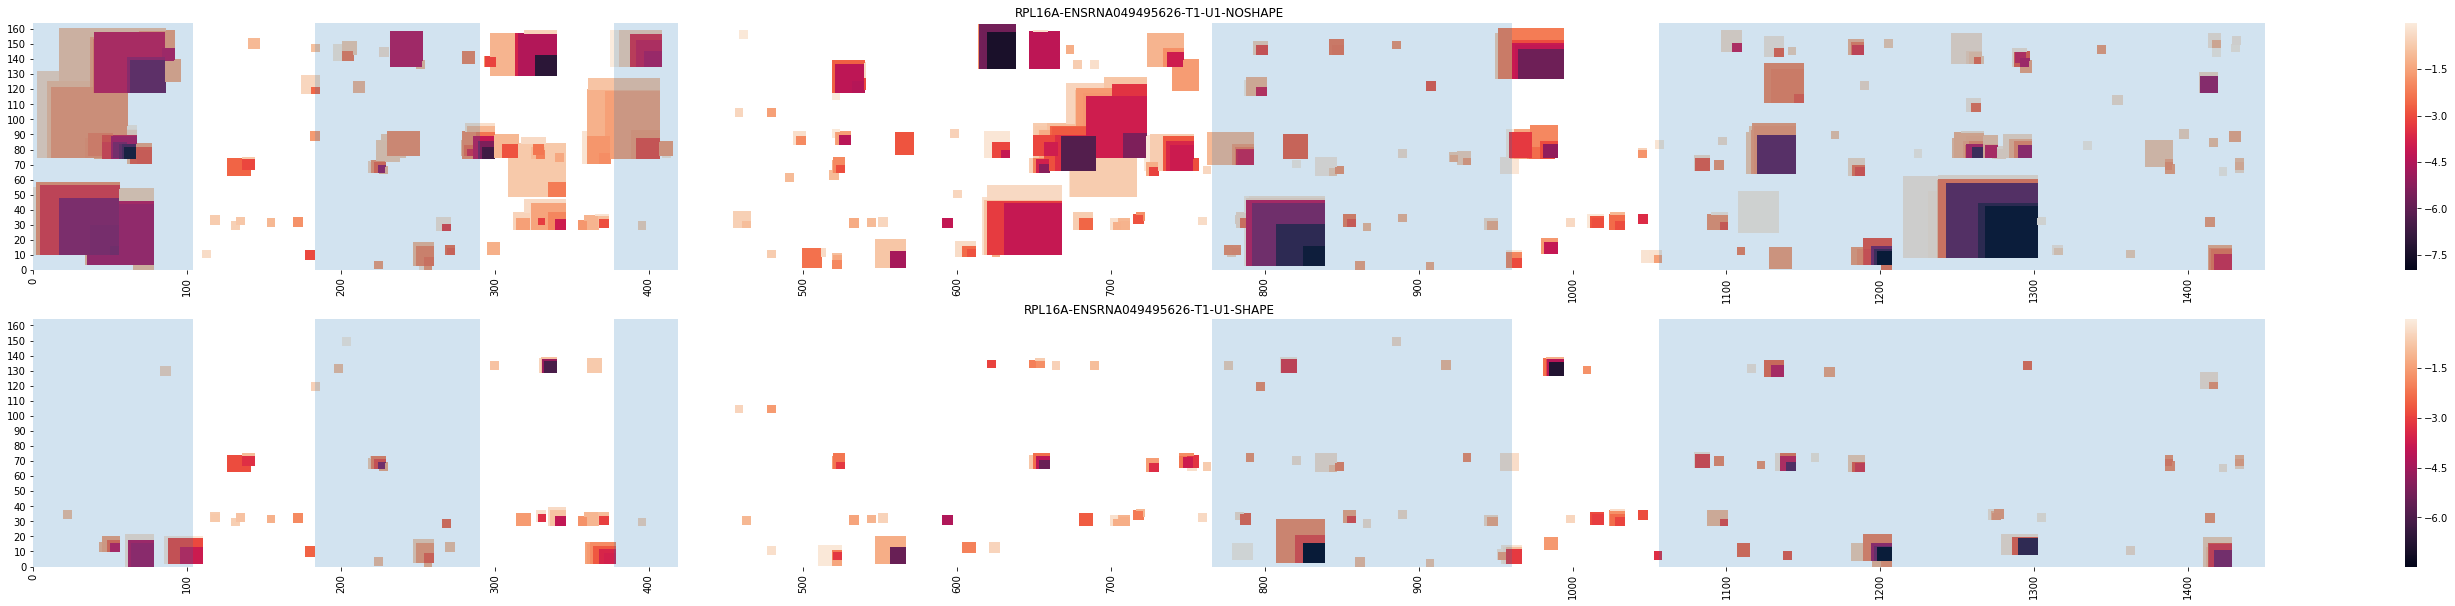

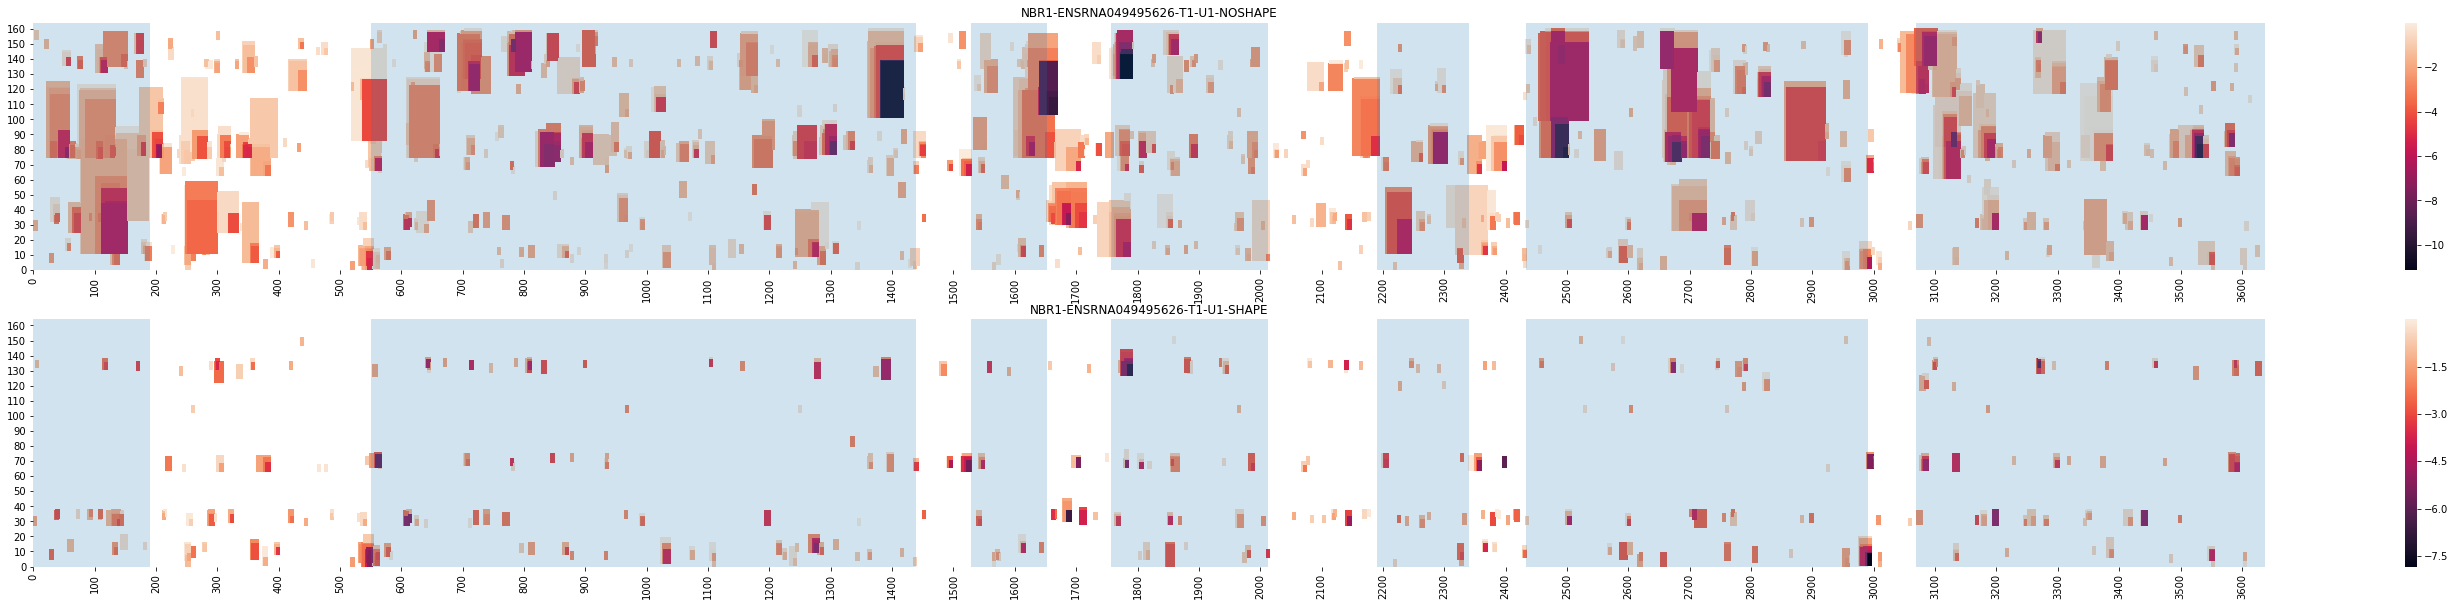